# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Feature reduction](#Feature-reduction)
* [Visualization](#Visualization)
* [Discussion](#Discussion)

# Introduction

In this notebook, we use tSNE to reduce the development data to two components and visualize them.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("white")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

time: 2.91 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 94.1 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "neg",
    "neu",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 298 ms


In [6]:
# uncomment lines to undersample data with stratify hack
# from sklearn.model_selection import train_test_split
#
# _, _, _, labels = train_test_split(
#     data,
#     labels,
#     test_size=3000,
#     random_state=SEED,
#     stratify=labels.valence,
# )
# data = data.loc[labels.index]

assert all(data.index == labels.index)
_ = gc_collect()

time: 106 ms


# Feature reduction

In [7]:
transformed_data = TSNE(
    init="pca", verbose=1, random_state=SEED, n_jobs=-1, square_distances=True
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.031s...
[t-SNE] Computed neighbors for 17703 samples in 22.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

Let's take a quick look at these distributions.

In [8]:
def print_stats(xy: np.ndarray) -> None:
    "Display some quick statistics."
    xy = pd.Series(xy)
    print(
        f"mean: {xy.mean()}",
        f"std. dev.: {xy.std()}",
        f"skew: {xy.skew()}",
        f"kurtosis: {xy.kurtosis()}",
        sep="\n",
    )


print_stats(X)
print()
print_stats(Y)

mean: 0.09206420183181763
std. dev.: 36.973941802978516
skew: 0.07816024869680405
kurtosis: -1.1602940559387207

mean: 0.08458907902240753
std. dev.: 32.617889404296875
skew: 0.08732622861862183
kurtosis: -1.0577280521392822
time: 24 ms


Skew is minimal. Both look platykurtic, but the means and standard deviations are on the same scale.

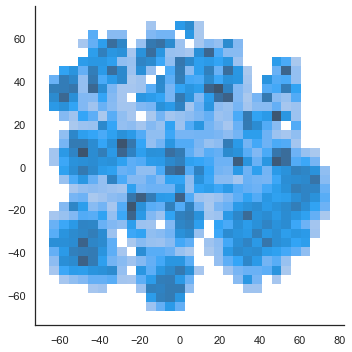

time: 763 ms


In [9]:
sns.displot(x=X, y=Y, palette="colorblind")

Could those be clusters representing the discrete emotion categories?

# Visualization

In [10]:
df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})
df.head()
df.info()

,X,Y,hue
0,9.030379,-4.009861,0
1,11.179118,-9.224844,0
2,8.960797,-1.777549,0
3,18.598282,15.278258,0
4,15.543962,-8.630537,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17703 entries, 0 to 17702
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       17703 non-null  float32
 1   Y       17703 non-null  float32
 2   hue     17703 non-null  int8   
dtypes: float32(2), int8(1)
memory usage: 155.7 KB
time: 33 ms


<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

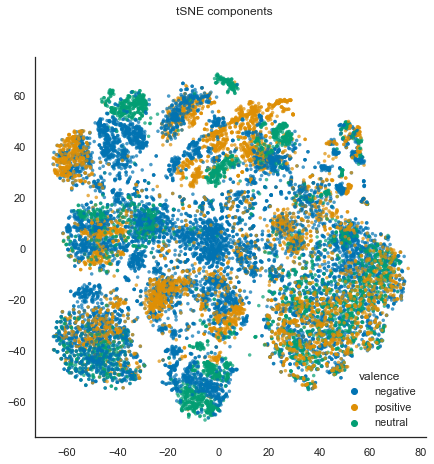

time: 1.89 s


In [11]:
sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

That was uninformative. Let's try with a new seed.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.045s...
[t-SNE] Computed neighbors for 17703 samples in 26.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

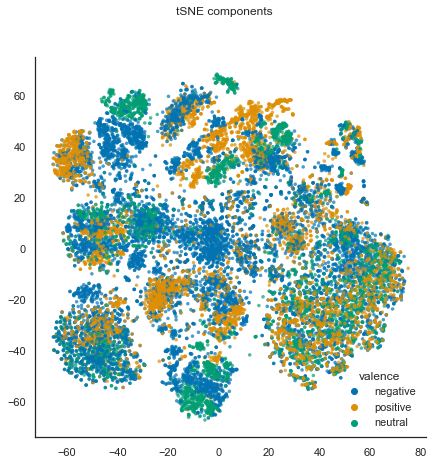

time: 2min 39s


In [12]:
transformed_data = TSNE(
    init="pca", verbose=1, random_state=SEED + 1, n_jobs=-1, square_distances=True
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

The new plot is still uninformative. Let's try with a new seed and `square_distances` set to `"legacy"`.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.058s...
[t-SNE] Computed neighbors for 17703 samples in 25.736s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

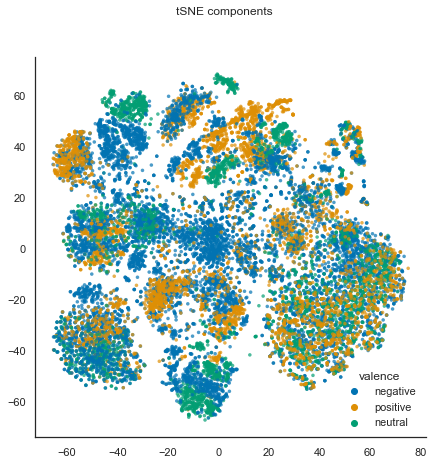

time: 2min 29s


In [13]:
transformed_data = TSNE(
    init="pca", verbose=1, random_state=SEED + 2, n_jobs=-1, square_distances="legacy"
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

The plot is almost identical. Maybe `sklearn`'s tSNE ignores `random_state` unless `init` is set to `"random"`.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.031s...
[t-SNE] Computed neighbors for 17703 samples in 22.282s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

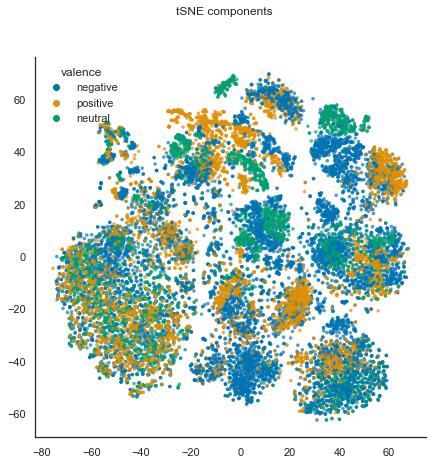

time: 2min 32s


In [14]:
transformed_data = TSNE(
    init="random", verbose=1, random_state=SEED, n_jobs=-1, square_distances=True
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

That wasn't much better. Let's try one more seed.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.042s...
[t-SNE] Computed neighbors for 17703 samples in 21.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

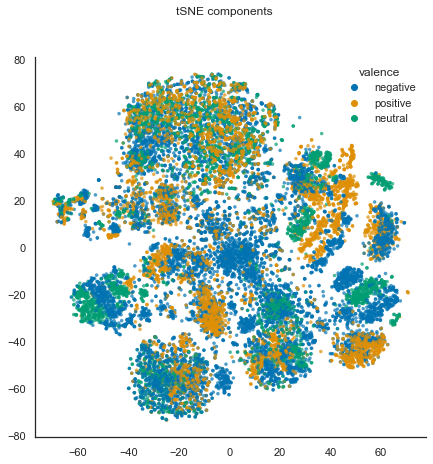

time: 2min 27s


In [15]:
transformed_data = TSNE(
    init="random", verbose=1, random_state=SEED + 1, n_jobs=-1, square_distances=True
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

Let's try one more time with a new seed and square_distances set to `"legacy"`.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.036s...
[t-SNE] Computed neighbors for 17703 samples in 22.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

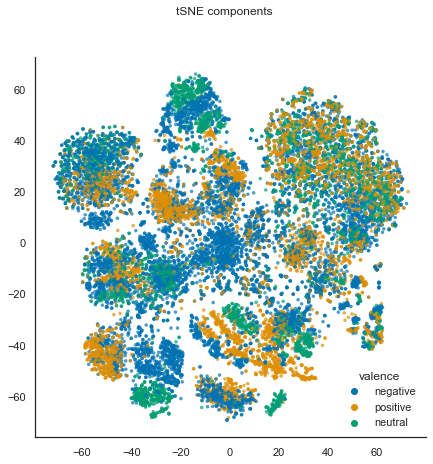

time: 2min 32s


In [16]:
transformed_data = TSNE(
    init="random",
    verbose=1,
    random_state=SEED + 10,
    n_jobs=-1,
    square_distances="legacy",
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.valence.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue.replace([0, 1, 2], ["negative", "neutral", "positive"]),
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="valence", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

# Discussion

tSNE has unfortunately fallen short of its reputation as a great visualization tool. However, it did run a lot faster than I expected. My hunch is that tSNE is picking up on the languages used in the dataset.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17703 samples in 0.043s...
[t-SNE] Computed neighbors for 17703 samples in 22.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17703
[t-SNE] Computed conditional probabilities for sample 2000 / 17703
[t-SNE] Computed conditional probabilities for sample 3000 / 17703
[t-SNE] Computed conditional probabilities for sample 4000 / 17703
[t-SNE] Computed conditional probabilities for sample 5000 / 17703
[t-SNE] Computed conditional probabilities for sample 6000 / 17703
[t-SNE] Computed conditional probabilities for sample 7000 / 17703
[t-SNE] Computed conditional probabilities for sample 8000 / 17703
[t-SNE] Computed conditional probabilities for sample 9000 / 17703
[t-SNE] Computed conditional probabilities for sample 10000 / 17703
[t-SNE] Computed conditional probabilities for sample 11000 / 17703
[t-SNE] Computed conditional probabilities for sample 12000 / 17703
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='X', ylabel='Y'>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'tSNE components')

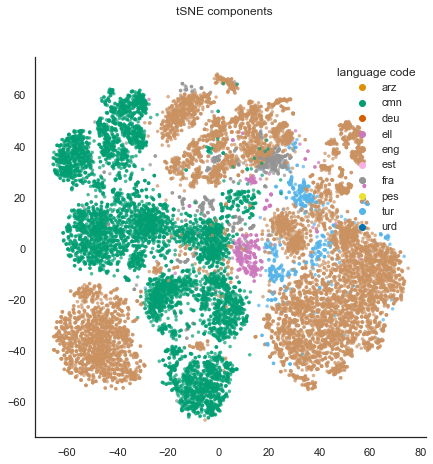

time: 2min 24s


In [17]:
transformed_data = TSNE(
    init="pca",
    verbose=1,
    random_state=SEED + 5,
    n_jobs=-1,
    square_distances=True,
).fit_transform(data)
X, Y = transformed_data[:, 0], transformed_data[:, 1]

print_stats(X)
print()
print_stats(Y)

df = pd.DataFrame({"X": X, "Y": Y, "hue": labels.lang1.values})

sns.scatterplot(
    x=df.X,
    y=df.Y,
    hue=df.hue,
    data=df,
    palette="colorblind",
    alpha=0.7,
    legend="brief",
    linewidth=0,
    marker=".",
    s=50,
)

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(7)

sns.despine(**dict.fromkeys(("top", "right"), True))
plt.legend(title="language code", frameon=False)
plt.xlabel("")
plt.ylabel("")
plt.suptitle("tSNE components")
plt.show()

Perhaps that was not a bad hunch. The sub-clusters within each language cluster could be reflective of emotion categories or gender maybe.

In [18]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time:.1f} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1078.7 s
time: 122 ms


[^top](#Contents)